In [1]:
import time

from tensorflow import keras 
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
aqi = pd.read_pickle('data/sh_bj_18to20_pm_delta.pkl', compression='bz2')
wind = pd.read_pickle('data/wind_sh_18to20.pkl', compression='bz2')

In [3]:
df = aqi.merge(wind, how = 'left', left_index=True, right_index=True)

In [4]:
df.drop(columns = ['type'], inplace=True)

In [5]:
inflow = df.copy()

In [6]:
inflow[['wind_x', 'wind_y']] = pd.DataFrame(inflow['wind_vector'].tolist(), index = inflow.index)

In [7]:
inflow['wind_x'] = inflow['wind_x']/inflow['wind speed']

In [8]:
inflow['wind_y'] = inflow['wind_y'] / inflow['wind speed']

In [9]:
inflow.drop(columns=['wind_vector', 'wind direction'], inplace=True)

In [10]:
inflow

,Shanghai,Beijing,Beijing-1h,Beijing-8h,Beijing-16h,Beijing-24h,Beijing-32h,Beijing-40h,Beijing-48h,Beijing-56h,...,Beijing-72h,Beijing-80h,Beijing-88h,Beijing-96h,Beijing-104h,Beijing-112h,Beijing-120h,wind speed,wind_x,wind_y
2018-01-01 00:00:00,175.00,33.000000,35.000000,42.777778,38.0,36.0,38.0,40.0,26.0,14.0,...,11.0,12.0,13.0,15.0,22.0,26.0,33.0,1.0,-0.999021,-0.044243
2018-01-01 01:00:00,178.00,35.000000,36.111111,43.888889,37.0,35.0,38.0,39.0,24.0,12.0,...,11.0,12.0,13.0,16.0,23.0,26.0,32.0,3.0,-0.448074,0.893997
2018-01-01 02:00:00,181.00,36.111111,37.222222,45.000000,38.0,35.0,39.0,37.0,23.0,11.0,...,11.0,12.0,13.0,17.0,23.0,26.0,31.0,3.0,0.814181,0.580611
2018-01-01 03:00:00,182.75,37.222222,38.333333,44.000000,38.0,35.0,40.0,35.0,22.0,11.0,...,11.0,12.0,13.0,18.0,24.0,26.0,30.0,2.0,-0.367291,-0.930106
2018-01-01 04:00:00,184.50,38.333333,39.444444,43.000000,38.0,36.0,40.0,33.0,20.0,10.0,...,11.0,12.0,13.0,19.0,24.0,28.0,29.0,3.0,-0.197814,0.980240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 19:00:00,24.00,14.000000,14.000000,18.000000,24.0,28.0,30.0,34.0,38.0,29.0,...,10.0,16.0,22.0,27.0,29.0,35.0,33.0,3.0,0.699251,-0.714876
2020-08-10 20:00:00,24.00,14.000000,13.000000,19.000000,25.0,28.0,30.0,35.0,37.0,28.0,...,10.0,17.0,23.0,27.0,30.0,35.0,33.0,4.0,0.699251,-0.714876
2020-08-10 21:00:00,23.00,13.000000,13.000000,20.000000,25.0,29.0,31.0,36.0,36.0,26.0,...,11.0,18.0,23.0,27.0,31.0,35.0,33.0,4.0,0.937995,0.346649
2020-08-10 22:00:00,23.00,13.000000,15.000000,21.000000,25.0,29.0,31.0,37.0,35.0,25.0,...,11.0,19.0,24.0,27.0,32.0,35.0,32.0,4.0,-0.975629,0.219425


In [11]:
work_df = inflow[['Shanghai', 'Beijing', 'wind_x', 'wind_y']]

In [13]:
# normalization
from sklearn.preprocessing import MinMaxScaler

inflow_scaled = inflow.drop(columns = ['Shanghai', 'wind_x', 'wind_y'])

scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(inflow_scaled)


In [14]:
inflow_scaled = pd.DataFrame(x_scaled)

In [15]:
inflow_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.110294,0.117647,0.146242,0.128676,0.121324,0.128676,0.136029,0.084559,0.040441,0.022059,0.029412,0.033088,0.036765,0.044118,0.069853,0.084559,0.110294,0.111111
1,0.117647,0.121732,0.150327,0.125000,0.117647,0.128676,0.132353,0.077206,0.033088,0.022059,0.029412,0.033088,0.036765,0.047794,0.073529,0.084559,0.106618,0.333333
2,0.121732,0.125817,0.154412,0.128676,0.117647,0.132353,0.125000,0.073529,0.029412,0.022059,0.029412,0.033088,0.036765,0.051471,0.073529,0.084559,0.102941,0.333333
3,0.125817,0.129902,0.150735,0.128676,0.117647,0.136029,0.117647,0.069853,0.029412,0.022059,0.029412,0.033088,0.036765,0.055147,0.077206,0.084559,0.099265,0.222222
4,0.129902,0.133987,0.147059,0.128676,0.121324,0.136029,0.110294,0.062500,0.025735,0.022059,0.029412,0.033088,0.036765,0.058824,0.077206,0.091912,0.095588,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22867,0.040441,0.040441,0.055147,0.077206,0.091912,0.099265,0.113971,0.128676,0.095588,0.051471,0.025735,0.047794,0.069853,0.088235,0.095588,0.117647,0.110294,0.333333
22868,0.040441,0.036765,0.058824,0.080882,0.091912,0.099265,0.117647,0.125000,0.091912,0.047794,0.025735,0.051471,0.073529,0.088235,0.099265,0.117647,0.110294,0.444444
22869,0.036765,0.036765,0.062500,0.080882,0.095588,0.102941,0.121324,0.121324,0.084559,0.044118,0.029412,0.055147,0.073529,0.088235,0.102941,0.117647,0.110294,0.444444
22870,0.036765,0.044118,0.066176,0.080882,0.095588,0.102941,0.125000,0.117647,0.080882,0.040441,0.029412,0.058824,0.077206,0.088235,0.106618,0.117647,0.106618,0.444444


In [16]:
inflow_sc = inflow[['Shanghai', 'wind_x', 'wind_y']].reset_index()

In [17]:
data = inflow_sc.merge(inflow_scaled, how='left', left_index=True, right_index=True)

In [18]:
data.drop(columns = ['index'], inplace=True)

In [142]:
data

,Shanghai,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,175.00,0.110294,0.117647,0.146242,0.128676,0.121324,0.128676,0.136029,0.084559,0.040441,0.022059,0.029412,0.033088,0.036765,0.044118,0.069853,0.084559,0.110294,0.111111
1,178.00,0.117647,0.121732,0.150327,0.125000,0.117647,0.128676,0.132353,0.077206,0.033088,0.022059,0.029412,0.033088,0.036765,0.047794,0.073529,0.084559,0.106618,0.333333
2,181.00,0.121732,0.125817,0.154412,0.128676,0.117647,0.132353,0.125000,0.073529,0.029412,0.022059,0.029412,0.033088,0.036765,0.051471,0.073529,0.084559,0.102941,0.333333
3,182.75,0.125817,0.129902,0.150735,0.128676,0.117647,0.136029,0.117647,0.069853,0.029412,0.022059,0.029412,0.033088,0.036765,0.055147,0.077206,0.084559,0.099265,0.222222
4,184.50,0.129902,0.133987,0.147059,0.128676,0.121324,0.136029,0.110294,0.062500,0.025735,0.022059,0.029412,0.033088,0.036765,0.058824,0.077206,0.091912,0.095588,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22867,24.00,0.040441,0.040441,0.055147,0.077206,0.091912,0.099265,0.113971,0.128676,0.095588,0.051471,0.025735,0.047794,0.069853,0.088235,0.095588,0.117647,0.110294,0.333333
22868,24.00,0.040441,0.036765,0.058824,0.080882,0.091912,0.099265,0.117647,0.125000,0.091912,0.047794,0.025735,0.051471,0.073529,0.088235,0.099265,0.117647,0.110294,0.444444
22869,23.00,0.036765,0.036765,0.062500,0.080882,0.095588,0.102941,0.121324,0.121324,0.084559,0.044118,0.029412,0.055147,0.073529,0.088235,0.102941,0.117647,0.110294,0.444444
22870,23.00,0.036765,0.044118,0.066176,0.080882,0.095588,0.102941,0.125000,0.117647,0.080882,0.040441,0.029412,0.058824,0.077206,0.088235,0.106618,0.117647,0.106618,0.444444


In [20]:
data.isnull().sum()

Shanghai     19
wind_x      353
wind_y      353
0            33
1            33
2            33
3            33
4            33
5            33
6            33
7            33
8            33
9            33
10           33
11           33
12           34
13           34
14           34
15           34
16           34
17            0
dtype: int64

In [12]:
work_df = work_df.fillna(20)

In [13]:
work_front = work_df.iloc[:-2872]
work_back = work_df.iloc[-2872:]

In [14]:
work_front

,Shanghai,Beijing,wind_x,wind_y
2018-01-01 00:00:00,175.00,33.000000,-0.999021,-0.044243
2018-01-01 01:00:00,178.00,35.000000,-0.448074,0.893997
2018-01-01 02:00:00,181.00,36.111111,0.814181,0.580611
2018-01-01 03:00:00,182.75,37.222222,-0.367291,-0.930106
2018-01-01 04:00:00,184.50,38.333333,-0.197814,0.980240
...,...,...,...,...
2020-04-13 03:00:00,53.00,18.000000,-0.283633,-0.958933
2020-04-13 04:00:00,53.00,18.000000,-0.991199,-0.132382
2020-04-13 05:00:00,52.00,19.000000,-0.991199,-0.132382
2020-04-13 06:00:00,52.00,19.000000,-0.991199,-0.132382


##  Get Training samples

In [15]:
##################
### length of seen hours
### temporal_horizon tells you the predicted hours

def get_sample(df, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length
    selected = True
    while selected:
        random_start = np.random.randint(0, last_possible)
        X_sample = df[random_start: random_start+length].values
        y_sample = df['Shanghai'][random_start+length+temporal_horizon]
        if y_sample == y_sample:
            selected = False
    
    return X_sample, y_sample


In [24]:
X, y =get_sample(inflow, 1000, 1)

In [25]:
X.shape

(1000, 21)

In [16]:
####################

def get_X_y(df, temporal_horizon, length_of_sequences, nb_samples):
    X, y = [], []

    for i in range(nb_samples):
        sample = get_sample(df, length_of_sequences, temporal_horizon)
        X.append(sample[0])
        y.append(sample[1])
        
    return np.array(X), np.array(y)


In [17]:
##################
### Given a dataframe, n_hrs to predict as temporal horizon

def generate_data(df, n_hrs, length_of_sequences, nb_samples):
    X, y = get_X_y(df, n_hrs, length_of_sequences, nb_samples)
    
    n_train = int(0.7*len(X))

    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    
    
    return X_train, X_test, y_train, y_test


In [28]:
len(y_train)

3

In [237]:
inflow.shape

(22872, 21)

### Initialize a model

In [18]:
###  

def init_model(ok):
    
    model = models.Sequential()
    model.add(layers.LSTM(30, input_shape=ok, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mae', 
                  optimizer='adam', 
                  metrics=['mae'])
    
    return model

In [241]:
X_train.shape

(3, 720, 21)

In [109]:
X_train.shape[1:]

(720, 20)

In [20]:
X_train, X_test, y_train, y_test = generate_data(work_front, 3, 72, 100)

model = init_model(X_train.shape[1:])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=1000, 
                    batch_size=32,
                    verbose=1,
                    callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 0s 210ms/step - loss: 38.5882 - mae: 38.5882 - val_loss: 36.2502 - val_mae: 36.2502
Epoch 2/1000
2/2 [==============================] - 0s 24ms/step - loss: 38.4474 - mae: 38.4474 - val_loss: 36.1667 - val_mae: 36.1667
Epoch 3/1000
2/2 [==============================] - 0s 24ms/step - loss: 38.3328 - mae: 38.3328 - val_loss: 36.0673 - val_mae: 36.0673
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 38.2287 - mae: 38.2287 - val_loss: 35.9604 - val_mae: 35.9604
Epoch 5/1000
2/2 [==============================] - 0s 25ms/step - loss: 38.1427 - mae: 38.1427 - val_loss: 35.8595 - val_mae: 35.8595
Epoch 6/1000
2/2 [==============================] - 0s 24ms/step - loss: 38.0549 - mae: 38.0549 - val_loss: 35.7514 - val_mae: 35.7514
Epoch 7/1000
2/2 [==============================] - 0s 23ms/step - loss: 37.9650 - mae: 37.9650 - val_loss: 35.6671 - val_mae: 35.6671
Epoch 8/1000
2/2 [==============================] - 0s

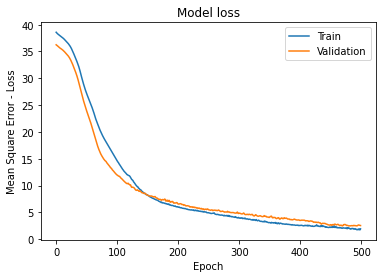

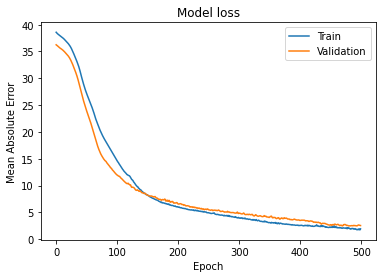

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)


In [186]:
X_test

array([[[0.23161765, 0.23529412, 0.27941176, ..., 0.03308824,
         0.04044118, 0.44444444],
        [0.23529412, 0.24264706, 0.27941176, ..., 0.03676471,
         0.04044118, 0.44444444],
        [0.24264706, 0.25      , 0.27941176, ..., 0.04044118,
         0.04044118, 0.38888889],
        ...,
        [0.16911765, 0.17647059, 0.22794118, ..., 0.11764706,
         0.06617647, 0.22222222],
        [0.17647059, 0.18382353, 0.23529412, ..., 0.11029412,
         0.05882353, 0.44444444],
        [0.18382353, 0.19117647, 0.24264706, ..., 0.10294118,
         0.05514706, 0.55555556]],

       [[0.0625    , 0.0625    , 0.06985294, ..., 0.12132353,
         0.05147059, 0.33333333],
        [0.0625    , 0.06617647, 0.06617647, ..., 0.11397059,
         0.05147059, 0.44444444],
        [0.06617647, 0.06617647, 0.06617647, ..., 0.09926471,
         0.05514706, 0.22222222],
        ...,
        [0.26470588, 0.27573529, 0.29411765, ..., 0.15073529,
         0.17647059, 0.66666667],
        [0.2

In [32]:
model.predict(X_test)

array([[44.890484],
       [16.909735],
       [31.35308 ],
       [31.388447],
       [89.91693 ],
       [43.645386],
       [34.148415],
       [40.84229 ],
       [11.048689],
       [23.277557],
       [31.523815],
       [12.276035],
       [40.349773],
       [46.100792],
       [19.990677],
       [24.593056],
       [22.16426 ],
       [28.209515],
       [38.818188],
       [45.085617],
       [42.333195],
       [34.218143],
       [69.10551 ],
       [75.6891  ],
       [34.20351 ],
       [28.735422],
       [24.84059 ],
       [62.913563],
       [58.865154],
       [33.06551 ]], dtype=float32)

In [22]:
def get_X_y_for_predict(df, temporal_horizon, length_of_sequences, nb_samples):
    X, y = [], []

    for i in range(nb_samples):
        sample = get_predict(df.iloc[i:], length_of_sequences, temporal_horizon)
        X.append(sample[0])
        y.append(sample[1])
        
    return np.array(X), np.array(y)

def get_predict(df, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length
    selected = True
    while selected:
        start = 0
        X_sample = df.iloc[start: start+length].values
        y_sample = df['Shanghai'].iloc[start+length+temporal_horizon]
        if y_sample == y_sample:
            selected = False
    
    return X_sample, y_sample

In [23]:
work_back.iloc[0]

Shanghai    51.000000
Beijing     20.000000
wind_x      -0.991199
wind_y      -0.132382
Name: 2020-04-13 08:00:00, dtype: float64

In [26]:
X_true, y_true = get_X_y_for_predict(work_back, 1, 24, 800)

In [27]:
y_pred = model.predict(X_true)

In [59]:
y_pred

array([[54.596287 ],
       [54.90969  ],
       [54.624813 ],
       [53.748978 ],
       [52.653973 ],
       [52.754368 ],
       [53.35457  ],
       [53.17464  ],
       [54.728165 ],
       [54.7793   ],
       [56.15661  ],
       [55.335213 ],
       [56.76822  ],
       [57.86403  ],
       [56.841225 ],
       [57.047573 ],
       [57.40336  ],
       [58.02867  ],
       [57.085747 ],
       [57.929493 ],
       [57.624714 ],
       [58.283836 ],
       [56.64429  ],
       [55.685474 ],
       [54.923363 ],
       [56.44814  ],
       [55.682285 ],
       [57.12098  ],
       [57.682564 ],
       [59.34086  ],
       [57.658756 ],
       [58.11237  ],
       [55.089943 ],
       [55.25294  ],
       [52.91587  ],
       [52.835426 ],
       [52.40818  ],
       [51.227028 ],
       [52.8369   ],
       [51.11084  ],
       [50.509155 ],
       [50.28596  ],
       [49.766006 ],
       [48.564205 ],
       [47.929916 ],
       [47.576035 ],
       [46.006557 ],
       [45.49

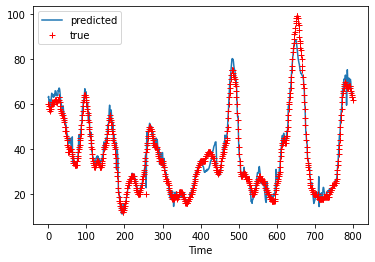

In [28]:
plt.plot(y_pred[:], label = 'predicted')
plt.plot(y_true[:], 'r+', label='true')
plt.legend()
plt.xlabel('Time')
plt.show()
#plt.savefig('lstm_prediction_3days.png', format='png')

# save model to pipeline

In [219]:
'''
import pickle

filename = 'pickle_data/lstm_model.pkl'
pickle.dump(model, open(filename, 'wb'))
'''

TypeError: can't pickle _thread.RLock objects

In [220]:
'''
from tensorflow.keras.models import models

filename = 'models/lstm_model.sav'
joblib.dump(model, filename)
'''

TypeError: can't pickle _thread.RLock objects

In [29]:
from tensorflow.keras.models import load_model

model.save('models/lstm_light_model.h5')

# Extract data from lstm

In [30]:
work_back.to_pickle('data/work_back.pkl', compression='bz2')